## Function Definition

In [135]:
import numpy as np
import json
import json5
import graphviz
import os
from IPython.display import display, Image

GLOBAL_SEED = 13520157
def linear(x):
    return x

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    if x.ndim == 2:
        x = x.T
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

## Class Definition

In [136]:
class FFNN:
    def __init__(self, n_neuron_each_layer=None, actfns=None, preweight=None):
        if n_neuron_each_layer is None:
            n_neuron_each_layer = [1, 1]
        self.Wdict = {}
        n_layer = len(n_neuron_each_layer)
        if actfns is None:
            actfns = ["linear"] * n_layer
        assert n_layer >= 2, "n_neuron_each_layer must have at least 2 elements (Input and Output)"
        assert all((isinstance(s, str) and callable(eval(s))) for s in actfns), "actfns must be a list of strings of callable functions"
        self.n_layer = n_layer
        self.n_neuron = n_neuron_each_layer
        self.actfns = [eval(s) for s in actfns]
        if preweight is None:
            for i in range(1, n_layer):
                np.random.seed(GLOBAL_SEED+i)
                self.Wdict[f'{i-1}-to-{i}'] = np.random.randn(n_neuron_each_layer[i-1]+1, n_neuron_each_layer[i])
        else:
            assert len(preweight) == n_layer - 1
            preweight = [np.array(w) for w in preweight]
            for i in range(1, n_layer):
                assert preweight[i-1].shape[0] == n_neuron_each_layer[i-1]+1
                assert preweight[i-1].shape[1] == n_neuron_each_layer[i]
                self.Wdict[f'{i-1}-to-{i}'] = preweight[i-1]
                # print(f'{i-1}-to-{i}: {self.Wdict[f"{i-1}-to-{i}"].shape}')

    def forward(self, data):
        assert data.ndim == 2
        assert data.shape[1] == self.n_neuron[0]
        # add bias
        data = np.hstack((np.ones((data.shape[0], 1)), data))
        for i, (k, v) in enumerate(self.Wdict.items()):
            data = self.actfns[i](data @ v)
            data = np.hstack((np.ones((data.shape[0], 1)), data))
        return data[:, 1:]

    def savetojson(self, filename):
        assert filename.endswith('.json')
        with open(filename, 'w') as f:
            data = {
                "n_neuron_each_layer": self.n_neuron,
                "actfns": [
                    "linear" if fn == linear else
                    "relu" if fn == relu else
                    "sigmoid" if fn == sigmoid else
                    "softmax" if fn == softmax else
                    "unknown"
                    for fn in self.actfns
                ],
                "preweight": [v.tolist() for k, v in self.Wdict.items()]
            }
            json.dump(data, f)

    @staticmethod
    def loadfromjson(filename):
        assert filename.endswith('.json')
        with open(filename, 'r') as f:
            data = json.load(f)
            return FFNN(data['n_neuron_each_layer'], data['actfns'], data['preweight'])

    def draw(self):
        graph = graphviz.Digraph(engine='neato')
        graph.attr(rankdir='LR')
        layer_spacing = 3  # Increase this value to increase the space between layers
        node_spacing = 2  # Increase this value to increase the space between nodes
        for i in range(self.n_layer):
            if i != self.n_layer - 1:
                graph.node(f'b_{i}', group=f'cluster_{i}', id=f"bias_{i}", pos=f'{i*layer_spacing},0!')
            for j in range(self.n_neuron[i]):
                graph.node(f'{i}_{j}', group=f'cluster_{i}',  pos=f'{i*layer_spacing},{-(j+1)*node_spacing}!')
        #Edges
        # List of colors to use for the edges
        colors = ['red', 'blue', 'green', 'purple', 'orange',
                  'brown', 'magenta', 'olive', 'navy']
        color_index = 0
        for layer in range(self.n_layer - 1):
            for cur_layer_i in range(-1, self.n_neuron[layer]):
                for next_layer_i in range(self.n_neuron[layer+1]):
                    tgt = f"{layer+1}_{next_layer_i}"
                    if cur_layer_i == -1:
                        src = f"b_{layer}"
                        bias = self.Wdict[f'{layer}-to-{layer+1}'][0,next_layer_i]
                        label = f'<<table border="0" cellborder="0"><tr><td></td></tr><tr><td>{bias:.2f}</td></tr></table>>'
                    else:
                        src = f"{layer}_{cur_layer_i}"
                        # Get the weight value for edge (src, tgt)
                        weight = self.Wdict[f'{layer}-to-{layer+1}'][cur_layer_i+1, next_layer_i]
                        label = f'<<table border="0" cellborder="0"><tr><td></td></tr><tr><td>{weight:.2f}</td></tr></table>>'
                    color = colors[color_index % len(colors)]
                    color_index += 1
                    graph.edge(src, tgt, label=label, color=color, fontcolor=color)

        graph.format = 'png'
        display(Image(graph.render('FFNN Graph')))


[[ 26.52835088]
 [ 11.28461957]
 [  3.7340899 ]
 [ -4.55918449]
 [ -2.82480024]
 [ -4.993677  ]
 [ 20.93587767]
 [ 37.93661885]
 [-11.94241614]
 [  8.35885033]]


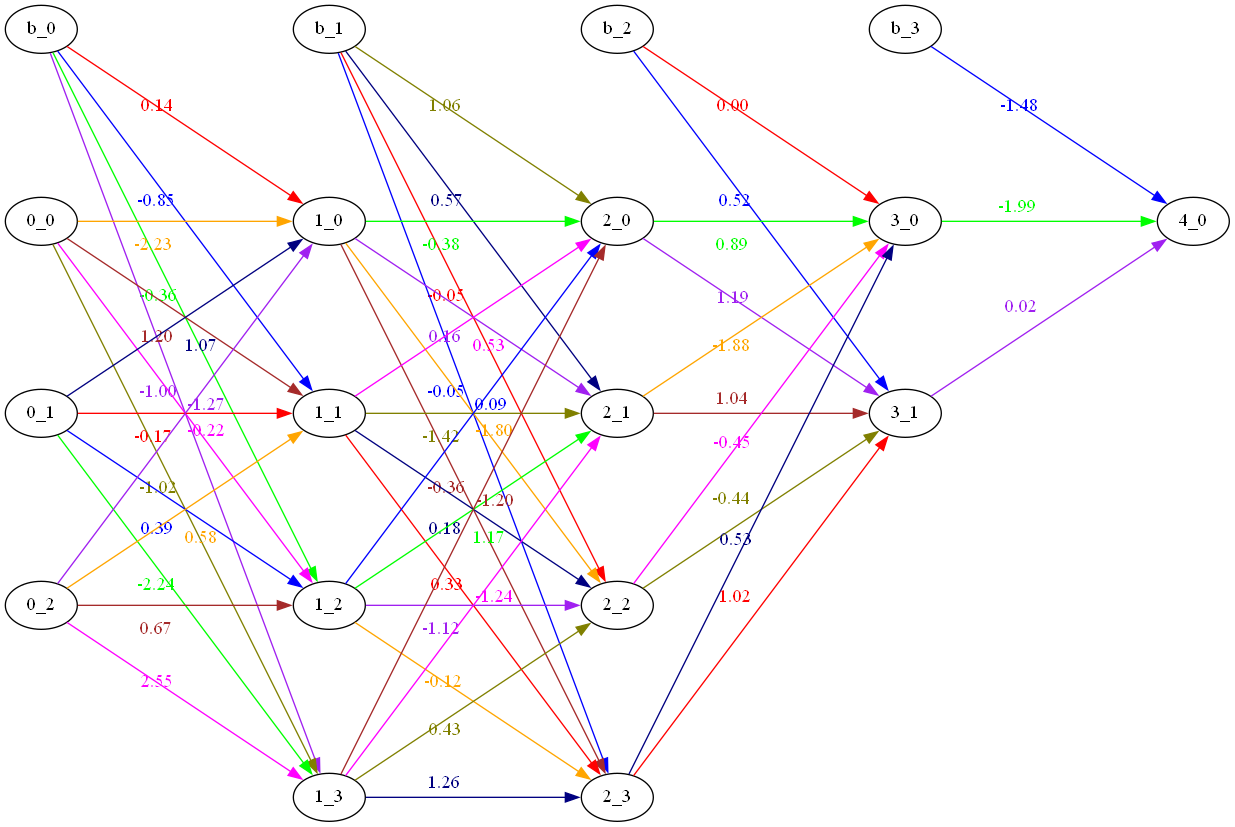

In [137]:
ff = FFNN([3, 4, 4, 2, 1])
np.random.seed(GLOBAL_SEED)
print(ff.forward(np.random.randn(10, 3)))
ff.savetojson('test.json')
ff.draw()

In [138]:
ff2 = FFNN.loadfromjson('test.json')
np.random.seed(GLOBAL_SEED)
print(ff2.forward(np.random.randn(10, 3)))

[[ 26.52835088]
 [ 11.28461957]
 [  3.7340899 ]
 [ -4.55918449]
 [ -2.82480024]
 [ -4.993677  ]
 [ 20.93587767]
 [ 37.93661885]
 [-11.94241614]
 [  8.35885033]]


In [139]:
def test_model(tc_filename):
    print(f"=== Testing {tc_filename} ===")
    with open(tc_filename, 'r') as f:
        data = json5.load(f)
        n_neuron_each_layer = []
        actfns = []
        preweight = data['case']['weights']
        n_neuron_each_layer.append(data['case']['model']['input_size'])
        for layer in data['case']['model']['layers']:
            n_neuron_each_layer.append(layer['number_of_neurons'])
            actfns.append(layer['activation_function'])
        input_data = np.array(data['case']['input'])
        model = FFNN(n_neuron_each_layer, actfns, preweight)
        output = model.forward(input_data)
        output_expected = np.array(data['expect']['output'])
        if output.shape[0] == output_expected.shape[1] and output.shape[1] == output_expected.shape[0]:
            output_expected = output_expected.T
        maximum_error = data['expect']['max_sse']
        # calculate output error
        output_error = np.sum((output - output_expected) ** 2)
        print(f'output: {output}')
        print(f'expected output: {output_expected}')
        print(f'output error: {output_error}')
        print(f'expected output error: {maximum_error}')
        print(f'output error <= expected output error: {output_error <= maximum_error}')
        print()


tc_folder = 'testcase'
tc_filename = [
    'linear.json',
    'multilayer.json',
    'relu.json',
    'sigmoid.json',
    'softmax.json',
]
for filename in tc_filename:
    test_model(os.path.join(tc_folder, filename))


=== Testing testcase\linear.json ===
output: [[ 2.   0.3 -1.9]]
expected output: [[ 2.   0.3 -1.9]]
output error: 2.2494861750442915e-31
expected output error: 1e-06
output error <= expected output error: True

=== Testing testcase\multilayer.json ===
output: [[2. 0.]
 [0. 2.]
 [0. 0.]]
expected output: [[2. 0.]
 [0. 2.]
 [0. 0.]]
output error: 0.0
expected output error: 1e-06
output error <= expected output error: True

=== Testing testcase\relu.json ===
output: [[0.05 1.1  0.  ]]
expected output: [[0.05 1.1  0.  ]]
output error: 4.8148248609680896e-33
expected output error: 1e-06
output error <= expected output error: True

=== Testing testcase\sigmoid.json ===
output: [[0.61774787 0.58904043 0.57444252]]
expected output: [[0.617747 0.58904  0.574442]]
output error: 1.2207224545374987e-12
expected output error: 1e-06
output error <= expected output error: True

=== Testing testcase\softmax.json ===
output: [[0.66524096 0.09003057 0.24472847]]
expected output: [[0.665241 0.090031 0.24